In [2]:
import json
import os
import pandas as pd
import numpy as np
import json
import watson_developer_cloud.natural_language_understanding.features.v1 as Features
import pdfminer
import textract
import re
import glob


from flask import jsonify
from scipy.spatial.distance import cdist
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import hierarchical, KMeans, MeanShift
from sklearn.model_selection import train_test_split
from watson_developer_cloud import NaturalLanguageUnderstandingV1

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from cStringIO import StringIO
import sys

def pdf_parser(data, count):

    fp = file(data, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data = retstr.getvalue()

    file_name = "Output" + str(count) + ".txt"
    data = data.decode('utf-8').encode('ascii', 'ignore')
    data = data.lower()
    text_file = file(file_name, "w")
    text_file.write(data)
    text_file.close()
    # print data
    return data

# Loops to create txt files for pdfs that are lowered and encoded ascii
def pdf_loop(directory, count):
    for filename in os.listdir(directory):
        if filename.endswith(".pdf"):
            path = directory + "\\" +filename
            pdf_parser(path, count)
            print(count)
            count += 1
            
            continue
        else:
            continue

In [39]:
# Reads text files. Loops directory and appends text to list
articles = []
def article_list(directory):
    articles = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            path = directory + "\\" + filename
            text = open(path, 'r').read()
            articles.append(text)
            continue
        else:
            continue
    return articles

# pdf_loop(r"data\obamacare-research-pdf", 1)
articles = article_list(r"C:\Users\austi\Google Drive\PycharmProjects\Debate-Bot\Watson-nlp\data\all-data")

In [40]:
print(len(articles))

8


In [41]:
def watson_text_analysis(text_):
    natural_language_understanding = NaturalLanguageUnderstandingV1(
      username="8fe00c1b-54ef-4291-a754-cbfcabecacfa",
      password="TguupnbIZO1Z",
      version="2017-02-27")
    # Limits to 2000 keywords, no emotion or sentiment
    response = natural_language_understanding.analyze(
      text=text_,
      features=[
        Features.Keywords(
          emotion=False,
          sentiment=False,
          limit=20
        )
      ]
    )
    my_dump = json.dumps(response, indent=2)
    my_load = json.loads(my_dump)
    new_dict = dict()
    for d in my_load['keywords']:
        lst = [k for k in d.keys()]
        for key in lst:
            new_dict[d[lst[1]]] = d[lst[0]]
    return new_dict

In [42]:
dictionary_list = []
for article in articles:
    d = watson_text_analysis(article)
    dictionary_list.append(d)
    
#d1 = watson_text_analysis(t1)
##d2 = watson_text_analysis(t2)
#d3 = watson_text_analysis(t3)

In [43]:
# Vocab set created from all articles
key_list = []
for article in dictionary_list:
    key_list.extend([k for k in article.keys()])
    
key_list=list(set(key_list))    
#key_list = [k for k in d1.keys()]
#key_list.extend([k for k in d2.keys()])
#key_list.extend([k for k in d3.keys()])
#print(key_list)

In [44]:
#dictionary_list = [d1, d2, d3]
new_list = []
# Adds 0's for words not in article but in vocabulary
for d in dictionary_list:
    e = dict()
    for key in key_list:
        if key in d.keys():
            e[key] = d[key]
        else:
            e[key] = 0.0
    new_list.append(e)

In [45]:
# Each article is a row. Each column is a dictionary key from our vocab.
df = pd.DataFrame(new_list)
df

,.........,acas pre-existing conditions,aspe data point,aspe issue,aspe issue brief,asylum,asylum office,asylum seekers,asylum applications,asylum cases,...,states,statutory cap,table,total medicaid spending,total spending,u.s. mainland,undocumented population,united states,united states,win-win immigration policies
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.63018,0.000000,0.885522,0.641835
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.928455,0.586789,0.000000,0.591003,0.633958,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.644995,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.437291,0.000000,0.394392,0.000000,0.000000,...,0.5725,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.666075,0.000000
4,0.94891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.324804,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.00000,0.389841,0.000000,0.565640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.00000,0.000000,0.998254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.506374,0.000000,0.481751,0.519222,0.000000,0.00000,0.000000,0.000000,0.000000
7,0.00000,0.000000,0.000000,0.713769,0.705842,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.698966,0.00000,0.000000,0.000000,0.000000


In [46]:
# Prints only keywords that add up from each column up to .8. Basically removes less relevent scores that add up to little
for key in new_list[0].keys():
    if new_list[0][key] + new_list[1][key] + new_list[2][key] > .80:
        print key, new_list[0][key], new_list[1][key], new_list[2][key]

human rights 0.0 0.842122 0.0
asylum 0.0 0.928455 0.437291
asylum seekers 0.0 0.911755 0.0
european union 0.0 0.0 0.918667
comprehensive immigration reform 0.821843 0.0 0.0
refugees 0.0 0.605494 0.603414
human security 0.705182 0.0 0.427803
united states 0.885522 0.0 0.0
immigration reform 0.87025 0.0 0.0
immigration policies 0.811518 0.0 0.0
immigration 0.95969 0.622126 0.0


In [47]:
clus_train, clus_test = train_test_split(df, test_size=.3, random_state=123)

In [48]:
from scipy.spatial.distance import cdist
clusters=range(1,5)
meandist=[]

In [49]:
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

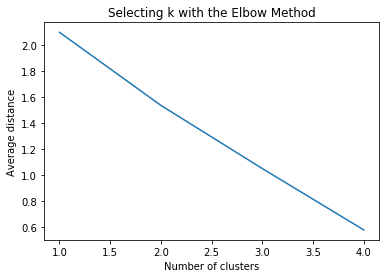

In [50]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

In [51]:
model3=KMeans(n_clusters=2)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

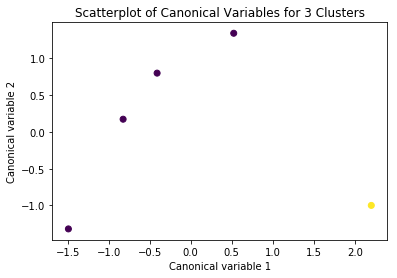

In [52]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

ValueError: Invalid RGBA argument: 1

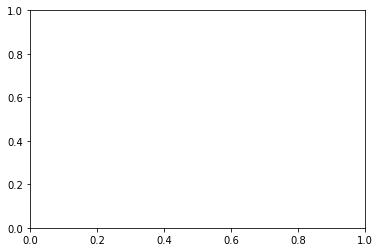

In [55]:
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()